In [1]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

# LFP registration, LFP interpolation, and AP interpolation demo

Here is an example workflow showing:
 - Motion tracking in the LFP band
 - Interpolation of the LFP band
 - Interpolation of the AP band

In this case, I'm running on a small segment of publicly shared d

Let me know what you think, what didn't work, what you don't like...

Start by following the installation instructions in `dredge-python/README.md`,
and then hopefully the below will work smoothly.

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# we use spikeinterface for all things preprocessing and data handling now
import spikeinterface.full as si
# these imports will move around as things evolve
# this is where the main online registration lives now
from dredge.dredge_lfp import register_online_lfp
# this has some helpers for plotting
import dredge.motion_util as mu

## Preprocessing

With spikeinterface, we can do preprocessing on the fly, so we don't need to save any copies of the data.
But, you can still save a copy if you want...

The preprocessing here is for a SpikeGLX recording, but most of these steps will work with any recording.
Since SpikeGLX gives us a .meta file with lots of info, this preprocessing can use all of it, including
automatically loading up the probe and electrode geometry, keeping track of the gain and offset to microvolts,
and correcting for ADC sample offsets.

I have another preprocessing chain for recordings with no saved metadata, which does less of this fancy
stuff but is still not bad, and which will read any old `.bin` or `.dat`. Happy to share that as well.

In [3]:
# preprocessing parameters
# brain surface cutoff point in microns
cutoff_um = None
# start and end times in seconds
t_start = 300.0 # nice data begins here
# t_end = 865.0 # the recording has nice data to here, but...
t_end = 420.0 # a 2 minute snip for demo purposes

In [4]:
# here, we do a preprocessing which downsamples to 250Hz for registration purposes
# below, when interpolating, we will not downsample.

# load up the spikeglx recordings
lfprec = si.read_spikeglx("/Users/charlie/data/NeuropixelsHumanData/Pt02/raw/", stream_id="imec0.lf")
lfprec

SpikeGLXRecordingExtractor: 384 channels - 2500.0Hz - 1 segments - 2,183,292 samples 
                            873.32s (14.56 minutes) - int16 dtype - 1.56 GiB

In [5]:
# aprec = si.read_spikeglx("/Users/charlie/data/NeuropixelsHumanData/Pt02/raw/", stream_id="imec0.ap")
# aprec

In [6]:
# trim the recordings to our ROI

# temporal trimming
lfprec = lfprec.frame_slice(
    start_frame=int(t_start * lfprec.sampling_frequency),
    end_frame=int(t_end * lfprec.sampling_frequency),
)
# aprec = aprec.frame_slice(
#     start_frame=int(t_start * aprec.sampling_frequency),
#     end_frame=int(t_end * aprec.sampling_frequency),
# )

# optional: remove channels outside the brain
# you could use similar logic to extract a single column
# or trim both ends of the probe, whatever you like
if cutoff_um is not None:
    geom = lfprec.get_channel_locations()
    lfprec = lfprec.remove_channels(lfprec.channel_ids[geom[:, 1] > cutoff_um])
    aprec = aprec.remove_channels(aprec.channel_ids[geom[:, 1] > cutoff_um])

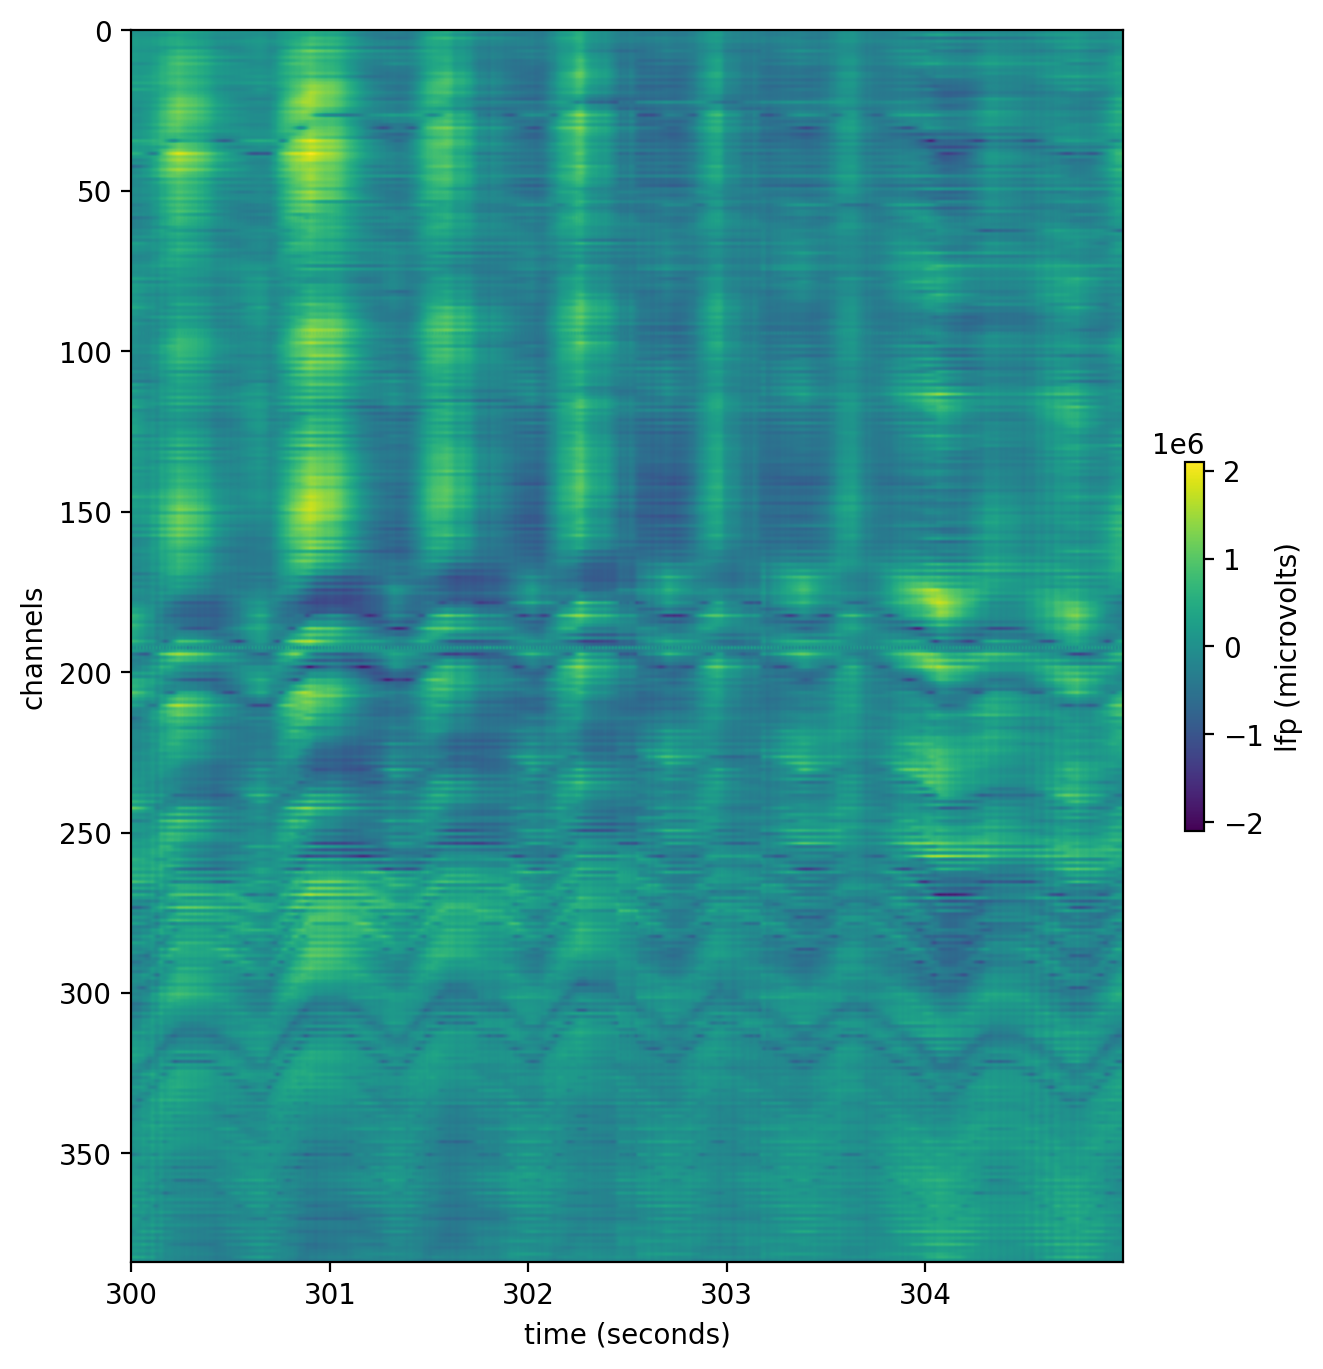

In [7]:
# let's take a look and see how the recording looks to start
vis_start_sample = 0
vis_length_samples = int(5 * lfprec.sampling_frequency)
fig, ax = plt.subplots(figsize=(8, 8))
im = mu.show_lfp_image(lfprec, vis_start_sample, vis_start_sample + vis_length_samples, ax, volts=True)
plt.colorbar(im, ax=ax, shrink=0.3, label="lfp (microvolts)");

In [8]:
# convert to floating point
lfprec = si.astype(lfprec, np.float32)

# ensure depth-ordered channel geometry
lfprec = si.depth_order(lfprec)

# bandpass filter
# we do an aggressive one since we plan to downsample
lfprec = si.bandpass_filter(
    lfprec,
    freq_min=0.5,
    freq_max=250,
    margin_ms=1000,
    filter_order=3,
    dtype="float32",
    add_reflect_padding=True,
)

# fancy bad channels detection and removal from the International Brain Lab
bad_chans, labels = si.detect_bad_channels(lfprec, psd_hf_threshold=1.4, num_random_chunks=100, seed=0)
print("Found bad channels", bad_chans)
lfprec = lfprec.remove_channels(bad_chans)

# correct for ADC sample shifts
lfprec = si.phase_shift(lfprec)

# common median reference
lfprec = si.common_reference(lfprec)

# downsample to 250Hz
lfprec = si.resample(lfprec, 250, margin_ms=1000)

Found bad channels ['imec0.lf#LF191' 'imec0.lf#LF205']


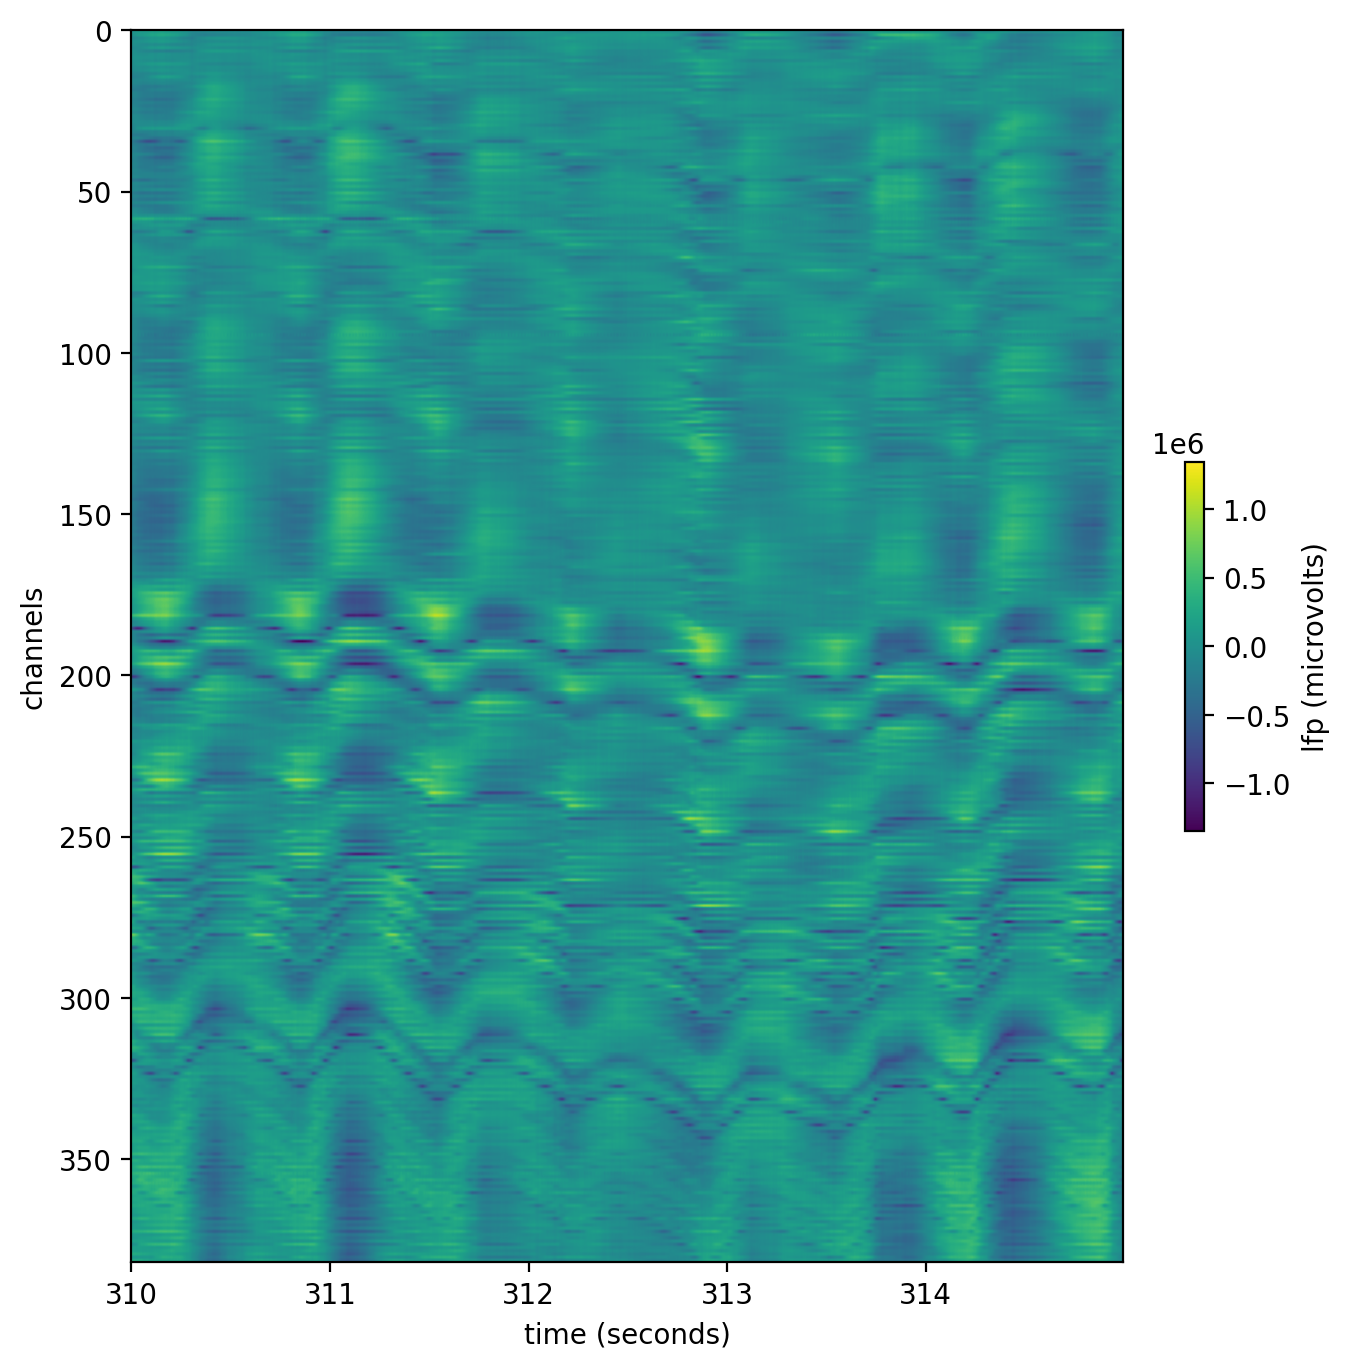

In [9]:
# after this preprocessing, how does it look?
vis_start_sample = int(10 * lfprec.sampling_frequency)
vis_length_samples = int(5 * lfprec.sampling_frequency)
fig, ax = plt.subplots(figsize=(8, 8))
im = mu.show_lfp_image(lfprec, vis_start_sample, vis_start_sample + vis_length_samples, ax, volts=True)
plt.colorbar(im, ax=ax, shrink=0.3, label="lfp (microvolts)");

In [10]:
# spatial filters: second derivative and averageing same-depth channels
lfprec = si.directional_derivative(lfprec, order=2, edge_order=1)
lfprec = si.average_across_direction(lfprec)

In [11]:
lfprec

AverageAcrossDirectionRecording: 192 channels - 250.0Hz - 1 segments - 30,000 samples 
                                 120.00s (2.00 minutes) - float32 dtype - 21.97 MiB

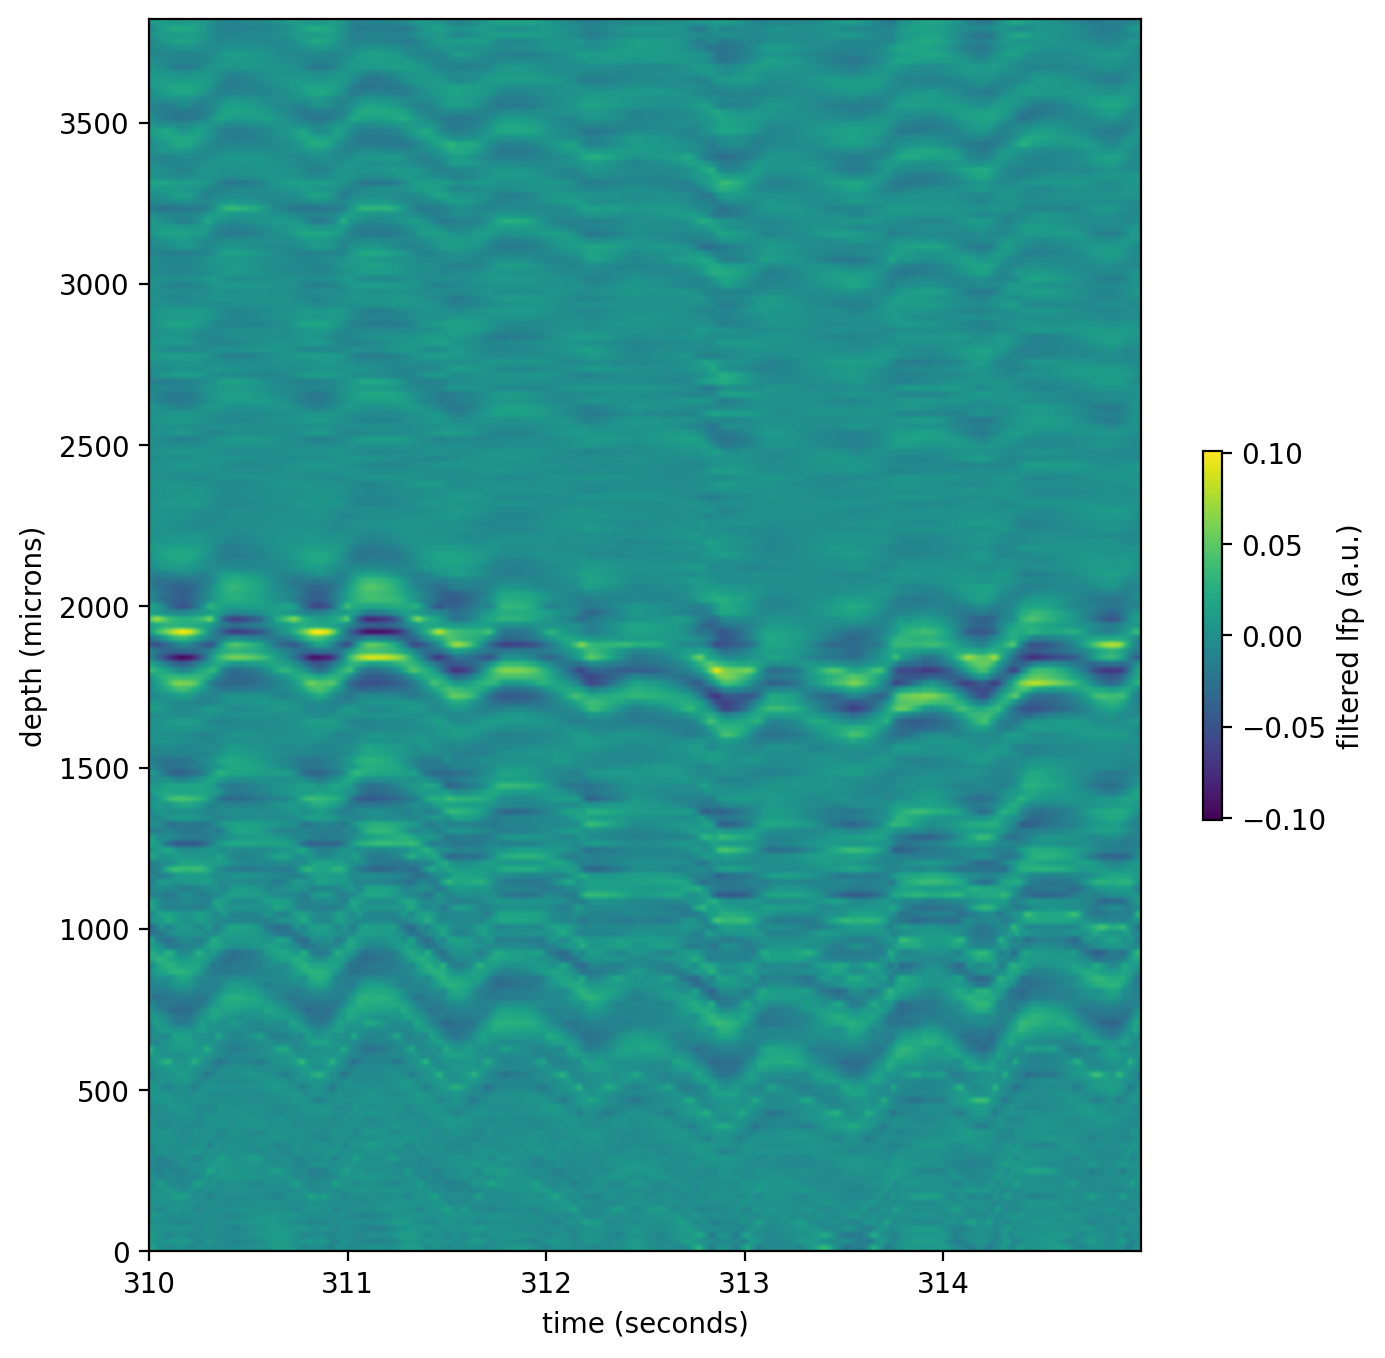

In [12]:
# how does it look after spatial filters?
vis_start_sample = int(10 * lfprec.sampling_frequency)
vis_length_samples = int(5 * lfprec.sampling_frequency)
fig, ax = plt.subplots(figsize=(8, 8))
im = mu.show_lfp_image(lfprec, vis_start_sample, vis_start_sample + vis_length_samples, ax, microns=True)
plt.colorbar(im, ax=ax, shrink=0.3, label="filtered lfp (a.u.)");

## Registration

For demo purposes, we'll do both rigid and nonrigid registration.

In [13]:
# if the timing looks slow, ignore it, I ran this on my laptop :P
me_rigid, extra_info_rigid = register_online_lfp(lfprec, max_disp_um=1000)

Online chunks [10.0s each]:   0%|          | 0/11 [00:00<?, ?it/s]

In [14]:
# nonrigid is slower by (approx) a factor of how many windows you want
# (although, on GPU, this can be negligible -- timings here are CPU)
# the default is windows with 800um spacing, which leads to about 5 windows on the dense NP1 electrode layout
# you can adjust the window spacing, width, and shape with the win_step_um, win_scale_um, and win_shape_um options
me_nonrigid, extra_info_nonrigid = register_online_lfp(lfprec, rigid=False, win_scale_um=1000, max_disp_um=500)

Online chunks [10.0s each]:   0%|          | 0/11 [00:00<?, ?it/s]

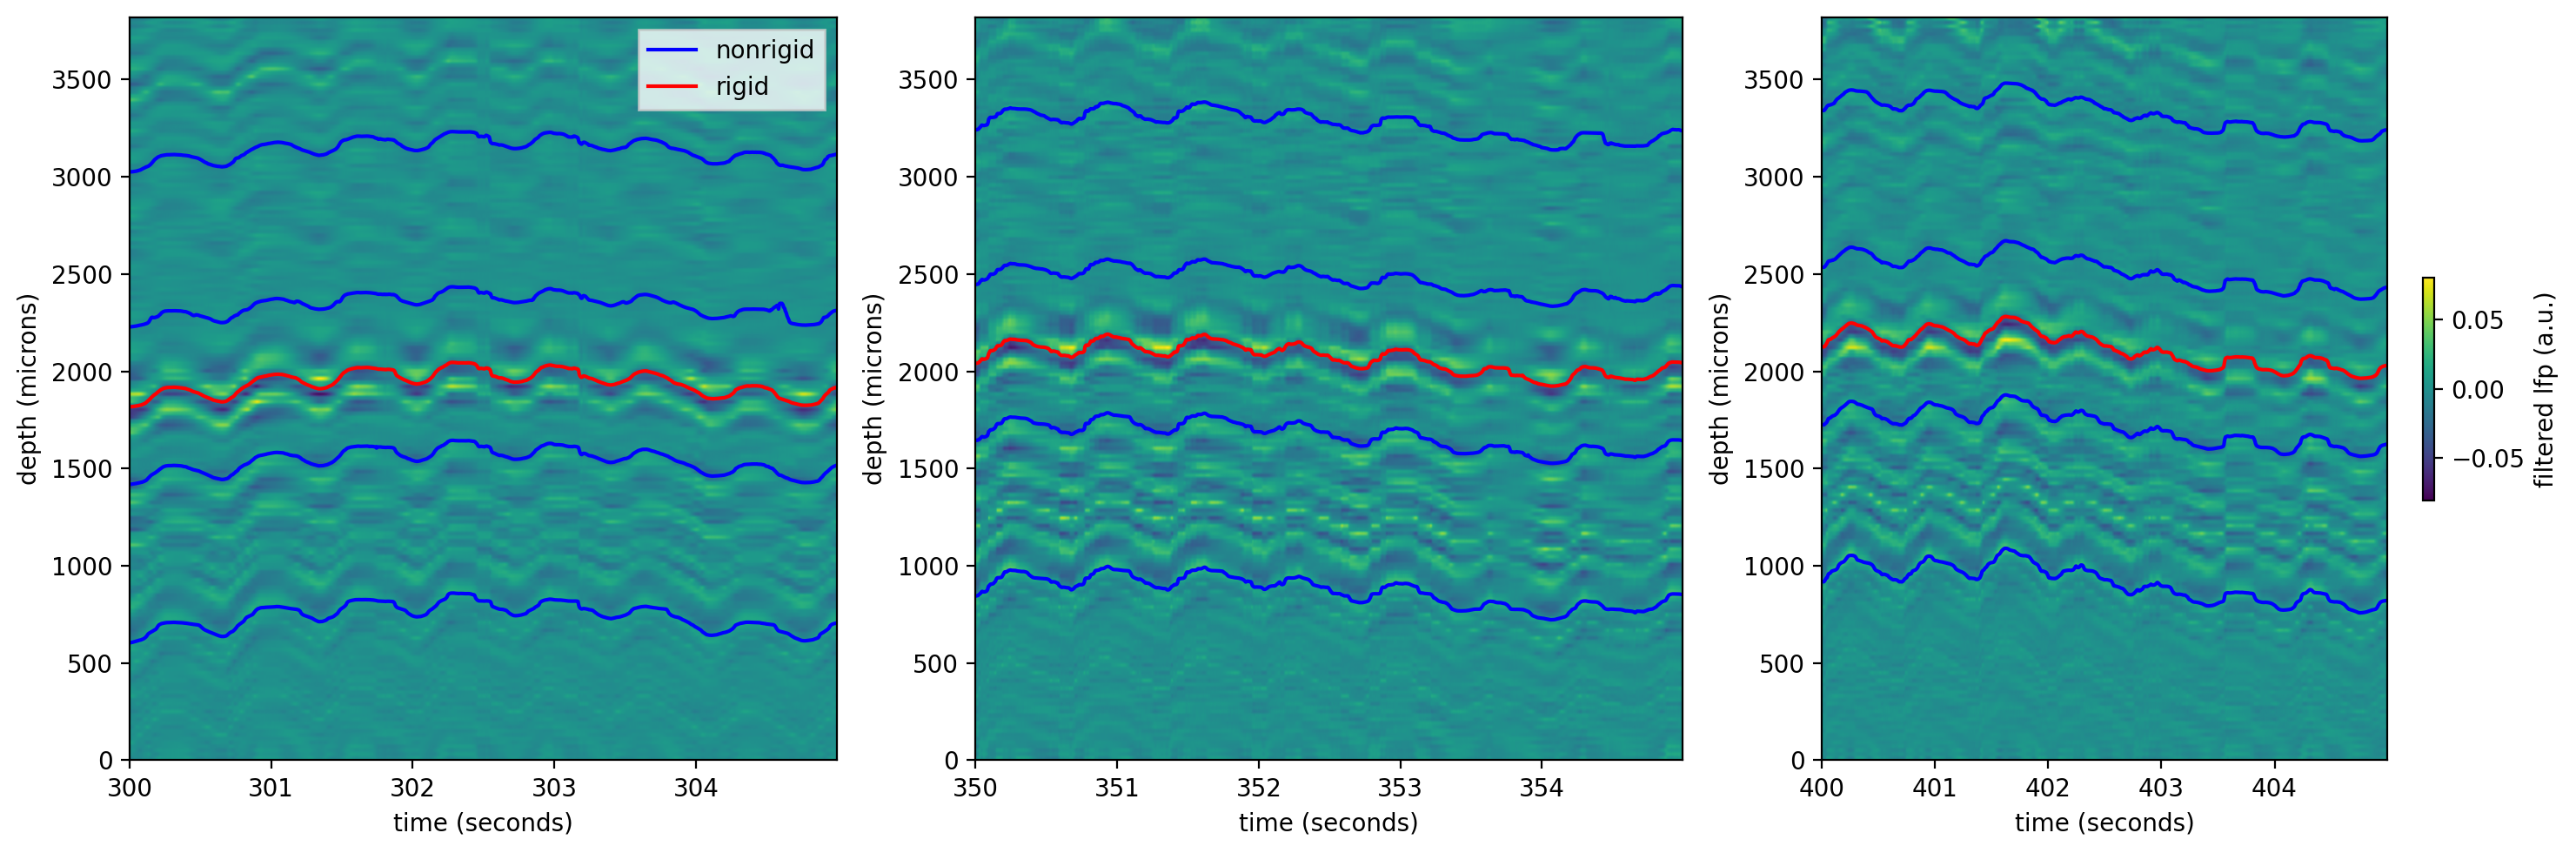

In [15]:
# visualize the result in several evenly spaced chunks of LFP

# chunk timing logic
vis_length_samples = int(5 * lfprec.sampling_frequency)
vis_spacing_samples = int(50 * lfprec.sampling_frequency)
vis_chunk_starts = range(0, lfprec.get_num_samples() - vis_length_samples, vis_spacing_samples)

# plotting
ncols = 3
nrows = int(np.ceil(len(vis_chunk_starts) / ncols))
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5 * ncols, 5 * nrows))

for j, (t0, ax) in enumerate(zip(vis_chunk_starts, axes.flat)):
    # show "CSD" image
    im = mu.show_lfp_image(lfprec, t0, t0 + vis_length_samples, ax, microns=True)
    if not (j + 1) % ncols:
        plt.colorbar(im, ax=ax, shrink=0.3, label="filtered lfp (a.u.)")
    
    # plot the motion estimate traces on top
    ln = mu.show_lfp_me_traces(me_nonrigid, t0, t0 + vis_length_samples, ax, color="b")
    lr = mu.show_lfp_me_traces(me_rigid, t0, t0 + vis_length_samples, ax, color="r")
    if not t0:
        ax.legend(handles=[ln, lr], labels=["nonrigid", "rigid"], fancybox=False)

# hide extra axes
for ax in axes.flat[len(vis_chunk_starts):]:
    ax.axis("off")

fig.tight_layout();

Clearly the nonrigid one has a couple of glitches, but only in the windows on the edge. Tweaking the window spacing and the window margin from the boundary might be enough to fix this up.

# Interpolation of the LFP band

Since we want to interpolate at the original frequency, we'll do the following steps:
 - Make a preprocessed version of the original recording at its original sampling rate (2.5kHz), and without the spatial filters
 - Use these with spikeinterface's interpolation

In [16]:
# preprocessing, again
lfprec_interp = si.read_spikeglx("/Users/charlie/data/NeuropixelsHumanData/Pt02/raw/", stream_id="imec0.lf")
lfprec_interp = si.astype(lfprec_interp, np.float32)

# spatial and temporal slice
lfprec_interp = lfprec_interp.frame_slice(
    start_frame=int(t_start * lfprec_interp.sampling_frequency),
    end_frame=int(t_end * lfprec_interp.sampling_frequency),
)
if cutoff_um is not None:
    geom = lfprec_interp.get_channel_locations()
    lfprec_interp = lfprec_interp.remove_channels(lfprec_interp.channel_ids[geom[:, 1] > cutoff_um])

# is 1000kHz too low?
# a highpass filter would probably be OK too.
lfprec_interp = si.bandpass_filter(
    lfprec_interp,
    freq_min=0.5,
    freq_max=1000,
    margin_ms=1000,
    filter_order=3,
    dtype="float32",
    add_reflect_padding=True,
)

bad_chans, labels = si.detect_bad_channels(lfprec_interp, psd_hf_threshold=1.4, num_random_chunks=100, seed=0)
print("Found bad channels", bad_chans)

# [!!!] a change from above
# here I'm choosing to interpolate the bad channels, rather than remove them.
# so, they are being filled in with some kriging interpolator. this seemed to
# make sense for the interpolation step, since maybe we'd like to keep the signal
# on all of the channels rather than having holes?
lfprec_interp = si.interpolate_bad_channels(lfprec_interp, bad_chans)

# correct for ADC sample shifts
lfprec_interp = si.phase_shift(lfprec_interp)

# common median reference
lfprec_interp = si.common_reference(lfprec_interp)
lfprec_interp

Found bad channels ['imec0.lf#LF191' 'imec0.lf#LF205']


CommonReferenceRecording: 384 channels - 2500.0Hz - 1 segments - 300,000 samples 
                          120.00s (2.00 minutes) - float32 dtype - 439.45 MiB

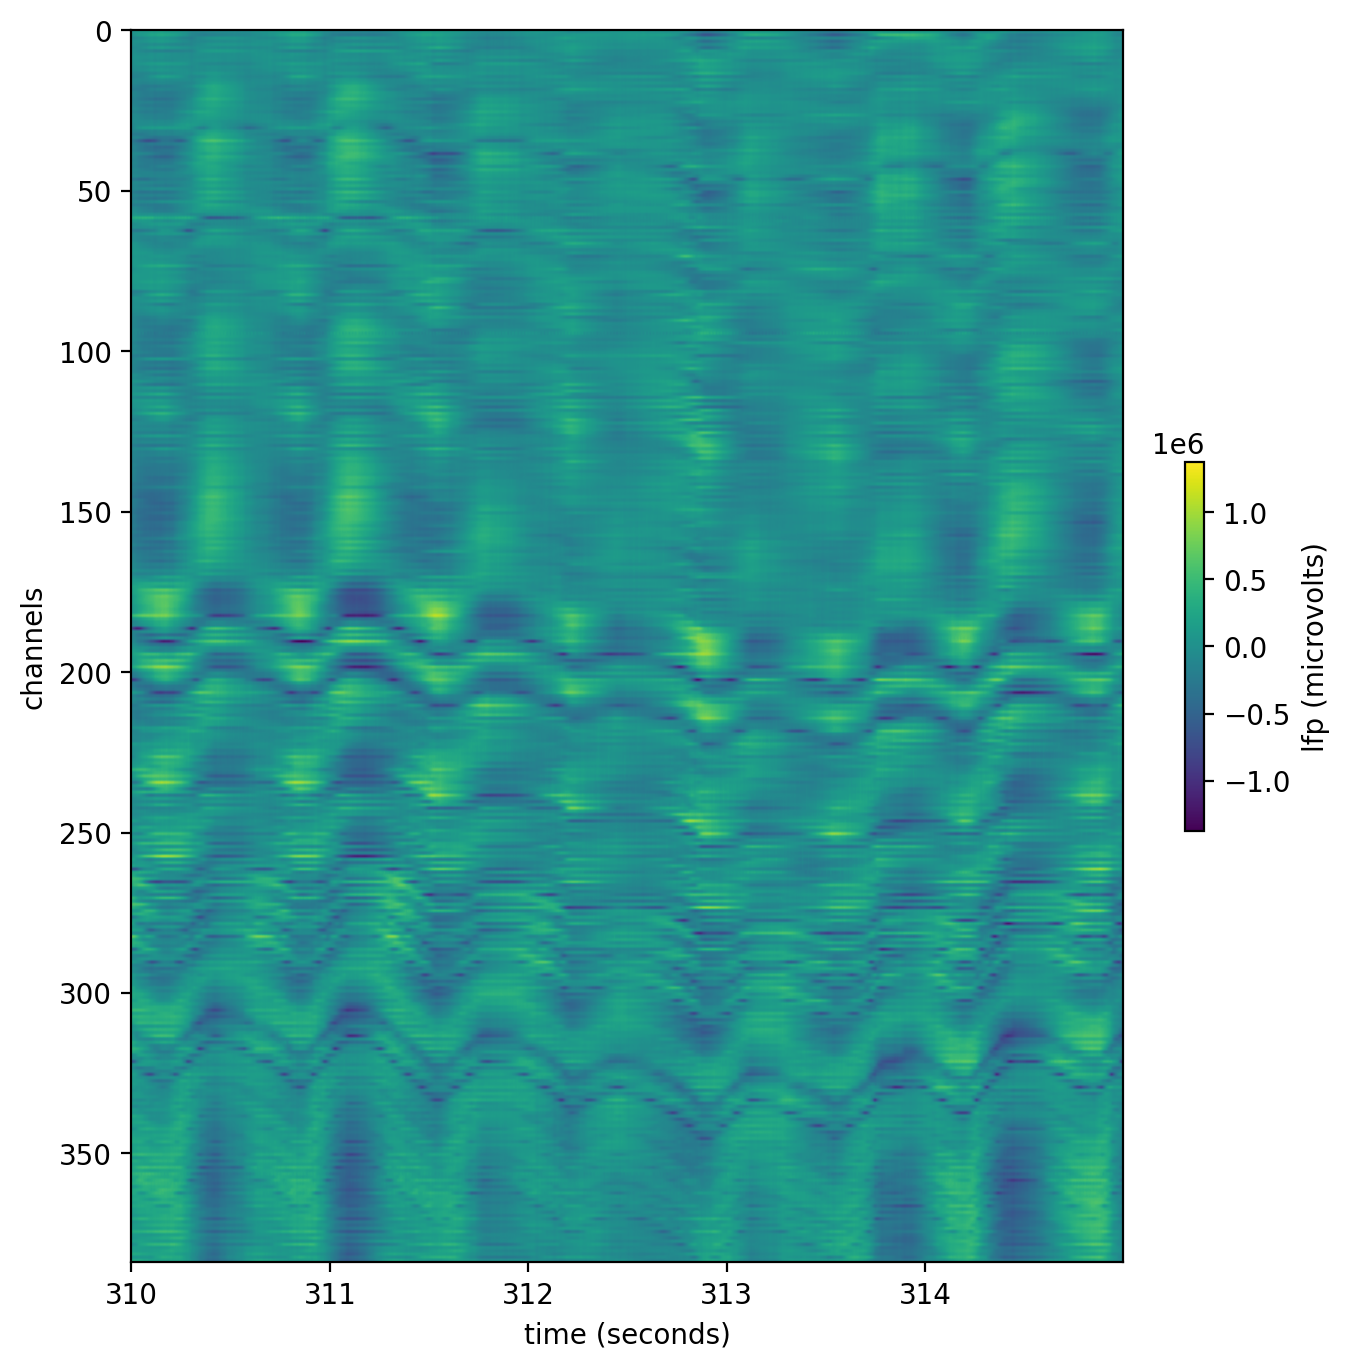

In [17]:
# visualize this preprocessing to check
vis_start_sample = int(10 * lfprec_interp.sampling_frequency)
vis_length_samples = int(5 * lfprec_interp.sampling_frequency)
fig, ax = plt.subplots(figsize=(8, 8))
im = mu.show_lfp_image(lfprec_interp, vis_start_sample, vis_start_sample + vis_length_samples, ax, volts=True)
plt.colorbar(im, ax=ax, shrink=0.3, label="lfp (microvolts)");

### Interpolate using SpikeInterface

For users interested in interpolating with SpikeInterface, note that SpikeInterface makes this whole pipeline available
using their tools now. There is no need to use our functions any more, but this tutorial notebook still exists for demo purposes.
See the links in our README for information on using SpikeInterface's pipeline.

In [18]:
# use our helper bridge function which asks spikeinterface to interpolate to correct motion
rigid_interp = mu.get_interpolated_recording(me_rigid, lfprec_interp)
nonrigid_interp = mu.get_interpolated_recording(me_nonrigid, lfprec_interp)

In [19]:
rigid_interp

interpolate_motion: 302 channels - 2500.0Hz - 1 segments - 300,000 samples 
                    120.00s (2.00 minutes) - float32 dtype - 345.61 MiB

In [20]:
nonrigid_interp

interpolate_motion: 302 channels - 2500.0Hz - 1 segments - 300,000 samples 
                    120.00s (2.00 minutes) - float32 dtype - 345.61 MiB

In [21]:
# to save the result, you can do:
rigid_interp_cached = rigid_interp.save(folder="/tmp/test_rigid_interp", n_jobs=4, overwrite=True)

write_binary_recording 
n_jobs=4 - samples_per_chunk=2,500 - chunk_memory=2.88 MiB - total_memory=11.52 MiB - chunk_duration=1.00s


write_binary_recording:   0%|          | 0/120 [00:00<?, ?it/s]

In [22]:
rigid_interp_cached

BinaryFolderRecording: 302 channels - 2500.0Hz - 1 segments - 300,000 samples 
                       120.00s (2.00 minutes) - float32 dtype - 345.61 MiB

In [23]:
nonrigid_interp_cached = rigid_interp.save(folder="/tmp/test_nonrigid_interp", n_jobs=4, overwrite=True)

write_binary_recording 
n_jobs=4 - samples_per_chunk=2,500 - chunk_memory=2.88 MiB - total_memory=11.52 MiB - chunk_duration=1.00s


write_binary_recording:   0%|          | 0/120 [00:00<?, ?it/s]

In [24]:
nonrigid_interp_cached

BinaryFolderRecording: 302 channels - 2500.0Hz - 1 segments - 300,000 samples 
                       120.00s (2.00 minutes) - float32 dtype - 345.61 MiB

In [25]:
# ^ those lines will dump a binary file called `traces_cached_seg0.raw` inside those folders, along with other metadata
# that binary file will be a flat float32 binary, similar to the usual .bin or .dat files

In [ ]:
# visualize the interpolation results

# chunk timing logic
vis_len_s = 1.0
vis_dt_s = 50

for t0 in range(int(t_start), int(t_start + lfprec_interp.get_total_duration()), vis_dt_s):
    print(t0)
    fig, (aa, ab, ac) = plt.subplots(ncols=3, figsize=(15, 5))
    
    # axis a will show original LFP and the motion estimates
    t0_interp = lfprec_interp.time_to_sample_index(t0)
    t1_interp = lfprec_interp.time_to_sample_index(t0 + vis_len_s)
    im = mu.show_lfp_image(
        lfprec_interp,
        t0_interp,
        t1_interp,
        aa,
        volts=True,
        microns=True,
    )
    plt.colorbar(im, ax=aa, shrink=0.3, label="lfp (microvolts)")
    t0_me = lfprec.time_to_sample_index(t0)
    t1_me = lfprec.time_to_sample_index(t0 + vis_len_s)
    ln = mu.show_lfp_me_traces(me_nonrigid, t0_me, t1_me, aa, color="b")
    lr = mu.show_lfp_me_traces(me_rigid, t0_me, t1_me, aa, color="r")
    aa.legend(handles=[ln, lr], labels=["nonrigid", "rigid"], fancybox=False)
    aa.set_title("original recording with motion estimates")
    
    # ab/ac show interpolated lfp
    print("rigid...")
    im = mu.show_lfp_image(rigid_interp, t0_interp, t1_interp, ab, microns=True, batched_mode=True)
    ab.set_title("rigid interpolation")
    print("nonrigid...")
    im = mu.show_lfp_image(nonrigid_interp, t0_interp, t1_interp, ac, microns=True, batched_mode=True)
    ac.set_title("nonrigid interpolation")
    
    fig.tight_layout()
    plt.show()
    plt.close(fig)

300
rigid...
